In [1]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
import yfinance as yf

from numpy import array
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [2]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [3]:
# FOR REPRODUCIBILITY
np.random.seed(7)

tickerSymbol = 'TSLA'
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
dataset = tickerData.history(period='1d', start='2010-1-1', end='2020-1-25',)

dataset=dataset[["Open","High","Low","Close"]]
# IMPORTING DATASET 
#dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
#dataset = dataset.reindex(index = dataset.index[::-1])

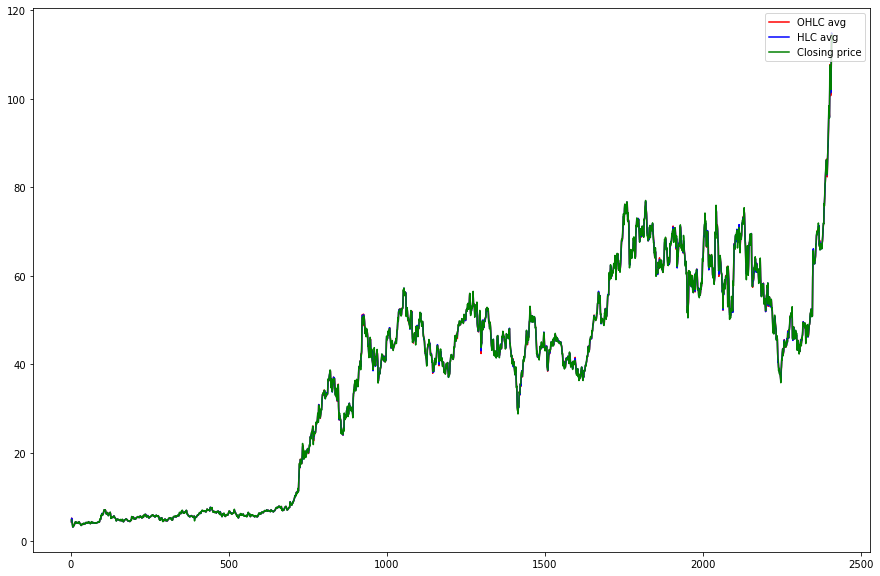

In [4]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.figure(figsize=(15, 10))
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()


In [5]:
# PREPARATION OF TIME SERIES DATASE
step_size = 4
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, step_size)
testX, testY = new_dataset(test_OHLC, step_size)

# RESHAPING TRAIN AND TEST DATA
n_seq = 2
step_size = 2

In [6]:
trainX = np.reshape(trainX, (trainX.shape[0], n_seq ,  step_size,1))
testX = np.reshape(testX, (testX.shape[0],n_seq, step_size,1))

In [7]:
# LSTM MODEL

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None,step_size,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# MODEL COMPILING AND TRAINING
#model.compile(loss='mean_squared_error', optimizer='SGD') # Try SGD, adam, adagrad and compare!!!
#model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)
model.fit(trainX, trainY,epochs=50, verbose=0)

In [8]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [9]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [10]:
# TRAINING RMSE
trainScore_RMSE = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
trainScore_MAE = np.sum(abs(trainY[0]-trainPredict[:,0]))/np.shape(trainY[0])
print('Train RMSE: %.2f' % (trainScore_RMSE))
print('Train MAE: %.2f' % (trainScore_MAE))

# TEST RMSE
testScore_RMSE = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testScore_MAE = np.sum(abs(testY[0]-testPredict[:,0]))/np.shape(testY[0])
testScore_r2=r2_score(testY[0], testPredict[:,0])
print('Test RMSE: %.2f' % (testScore_RMSE))
print('Test MAE: %.2f' % (testScore_MAE))
print('Test R2: %.2f' % (testScore_r2))

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+5:len(OHLC_avg)-1, :] = testPredict

Train RMSE: 1.12
Train MAE: 0.75
Test RMSE: 2.20
Test MAE: 1.54
Test R2: 0.96


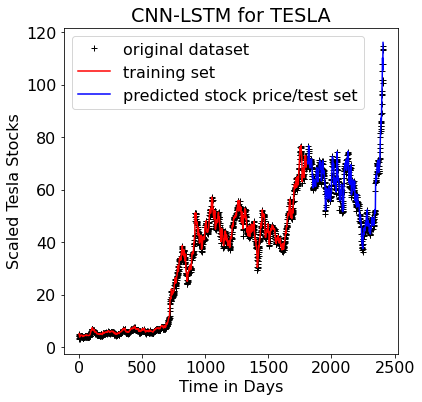

In [38]:

plt.rcParams['font.size'] = '16'
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(6, 6))
plt.plot(OHLC_avg, 'k+', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('Scaled Tesla Stocks')

t= r'RMSE=30.79'+ '\n MAE=21.61'+ '\n R$^{2}$=0.99'
plt.text(1500, 1200,t)

plt.title('CNN-LSTM for TESLA')
plt.savefig('TESLA_CNN_LSTM_6x6.png')
plt.show()
#plt.savefig('TESLA_CNN_LSTM_9x6.png')


In [20]:
t= r'RMSE=30.79'+ '\n MAE=21.61'+ '\n R$^{2}$=0.99'
plt.text(1500, 1200,t)



In [39]:
# FOR REPRODUCIBILITY
np.random.seed(7)

tickerSymbol = 'IWC'
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
dataset = tickerData.history(period='1d', start='2010-1-1', end='2020-1-25',)

dataset=dataset[["Open","High","Low","Close"]]
# IMPORTING DATASET 
#dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
#dataset = dataset.reindex(index = dataset.index[::-1])

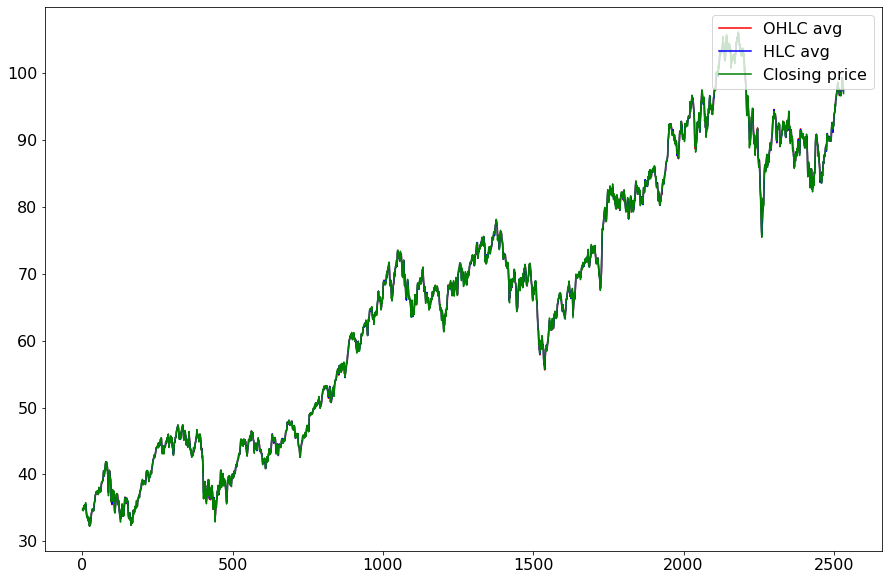

Test RMSE: 1.27
Test MAE: 0.88
Test R2: 1.00


In [40]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.figure(figsize=(15, 10))
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

# PREPARATION OF TIME SERIES DATASE
step_size = 4
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
#train_OHLC = int(len(OHLC_avg) * 0.75)
#test_OHLC = len(OHLC_avg) - train_OHLC
#train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]
test_OHLC = OHLC_avg

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
#trainX, trainY = new_dataset(train_OHLC, step_size)
testX, testY = new_dataset(test_OHLC, step_size)

# RESHAPING TRAIN AND TEST DATA
n_seq = 2
step_size = 2

#trainX = np.reshape(trainX, (trainX.shape[0], n_seq ,  step_size,1))
testX = np.reshape(testX, (testX.shape[0],n_seq, step_size,1))

# PREDICTION
#trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-NORMALIZING FOR PLOTTING
#trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# TRAINING RMSE
#trainScore_RMSE = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
#trainScore_MAE = np.sum(abs(trainY[0]-trainPredict[:,0]))/np.shape(trainY[0])
#print('Train RMSE: %.2f' % (trainScore_RMSE))
#print('Train MAE: %.2f' % (trainScore_MAE))

# TEST RMSE
testScore_RMSE = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testScore_MAE = np.sum(abs(testY[0]-testPredict[:,0]))/np.shape(testY[0])
testScore_r2=r2_score(testY[0], testPredict[:,0])
print('Test RMSE: %.2f' % (testScore_RMSE))
print('Test MAE: %.2f' % (testScore_MAE))
print('Test R2: %.2f' % (testScore_r2))

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
#trainPredictPlot = np.empty_like(OHLC_avg)
#trainPredictPlot[:, :] = np.nan
#trainPredictPlot = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot = testPredict

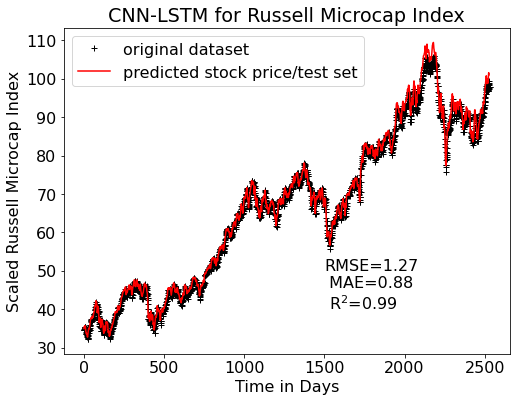

In [50]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8, 6))
plt.plot(OHLC_avg, 'k+', label = 'original dataset')
#plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'r', label = 'predicted stock price/test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('Scaled Russell Microcap Index')
plt.title('CNN-LSTM for Russell Microcap Index')

#plt.text(0.05, 0.95, textstr,fontsize=14)
t= r'RMSE=1.27'+ '\n MAE=0.88'+ '\n R$^{2}$=0.99'

plt.text(1500, 40,t)

plt.savefig('Russell_Microcap_Index_Bidirectional_LSTM_6x6.png')
plt.show()
#plt.savefig('TESLA_CNN_LSTM_6x6.png')